---
---
# **Clickbait Content Spoiling**

---
---
## Abstract

This notebook presents the project's objective, approach, and observations regarding Task 2 of the [Clickbait Challenge at SemEval 2023](https://pan.webis.de/semeval23/pan23-web/clickbait-challenge.html). The aim is to generate informative spoilers for clickbait posts using a fine-tuned flan-t5-base transformer model solely on the post clickbait title, content and human-generated spoilers provided in the dataset. The approach harnesses the transformer's sequence-to-sequence architecture to create coherent and informative spoilers. The findings underscore the transformer's efficacy in producing contextually relevant spoilers, showcasing its potential in enhancing clickbait spoiling techniques. This report provides insights into the effectiveness of transformer-based models for generating compelling content that piques readers' curiosity while adhering to the challenge's objectives.

---
---
## Table of Contents

>[Clickbait Content Spoiling](#scrollTo=jS4TDEkfQGdS)

>>[Abstract](#scrollTo=eqHZXclYQGbB)

>>[Table of Contents](#scrollTo=UEplxkDaQGY9)

>>[Background](#scrollTo=E-IEK_4mQgrt)

>>>[Clickbait Spoiling Task](#scrollTo=KfxZJdDt999x)

>>>[Conditional Generation Task](#scrollTo=P0GoKBgz8Yyd)

>>>[Dataset](#scrollTo=jZ5fdHEY_QNH)

>>[Implementation](#scrollTo=pPoaLvhZQnLa)

>>>[Setup](#scrollTo=DvYUOv8RRCcx)

>>>[Imports](#scrollTo=RROIj03oRCQP)

>>>[Dataset: Preparation](#scrollTo=wPzIozEgRCGx)

>>>[Dataset: Exploration](#scrollTo=yYxSrwnuWOv6)

>>>>[Example: Clickbait and Spoiler](#scrollTo=w8rtaEG5W04a)

>>>>[Max Sequence Lengths](#scrollTo=JuClX-avWvr1)

>>>[Dataset: Tokenization](#scrollTo=hfX7y0ylUO11)

>>>[Evaluation Metrics](#scrollTo=jPvwSMLvY9IC)

>>>[Data Collation](#scrollTo=7jmDUcT2c5Ee)

>>>[Fine-Tuning](#scrollTo=c0vCqQ38dheG)

>>>[Inference](#scrollTo=X509pE-iOYbq)



---
---
## Background

### Clickbait Spoiling Task

Clickbait posts link to web pages and advertise their content by arousing curiosity instead of providing informative summaries. Clickbait spoiling aims at generating short texts that satisfy the curiosity induced by a clickbait post.

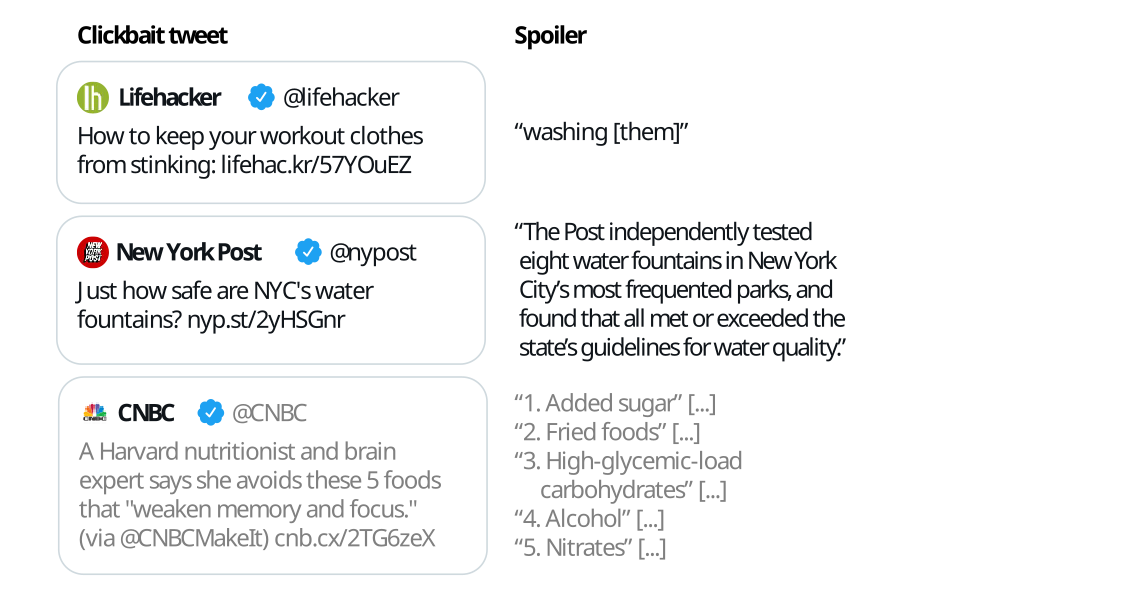

### Conditional Generation Task

Sequence-to-sequence tasks are defined as a mapping from an input sequence $X_{1:n}$ to an output sequence $Y_{1:m}$ of a-priori unknown output length $m$.  Hence, a sequence-to-sequence model should define the conditional probability distribution of the output sequence $Y_{1:m}$ conditioned on the input sequence $X_{1:n}$.

At the heart of sequence-to-sequence models is the full transformer architecture, which consists of two main components: an encoder and a decoder. This architecture is well-suited for tasks where the length of the input and output sequences can vary.

**Encoder:**
The encoder's role is to process the input sequence and create a fixed-size representation, often referred to as the context vector. This vector aims to capture the salient information from the input sequence and serve as a condensed representation of the input's meaning.

**Decoder:**
The decoder takes the context vector produced by the encoder and generates the output sequence one token at a time. It is essentially an autoregressive language model that conditions its generation on the context vector and previously generated tokens. During training, the decoder learns to predict the next token in the output sequence given the context vector and the tokens generated so far. Beam search or other decoding strategies are often employed at inference time to generate coherent and diverse sequences.

**Training:**
Encoder-Decoder models are trained using pairs of input and target sequences. The encoder processes the input sequence, and its final hidden state is used to initialize the decoder's hidden state. The decoder is then trained to generate the target sequence by predicting each token in the sequence sequentially. Training typically involves minimizing the negative log likelihood of the predicted tokens compared to the ground truth tokens.

### Dataset

The Webis Clickbait Spoiling Corpus contains
5,000 spoiled clickbait posts crawled from Facebook, Reddit, and Twitter. This dataset contains the clickbait posts and manually cleaned versions
of the linked documents, and extracted spoilers
for each clickbait post. Additionally, the spoilers are categorized into three types: short phrase
spoilers, longer passage spoilers, and multiple non-
consecutive pieces of text.

The dataset comes with predefined train/validation/test splits:


*   3,200 posts for training
*   800 posts for validation
*   1,000 posts for testing (omitted from the dataset)

Thus, for development, the training samples are
split into 3,000 for training and 200 for validation.
The 800 validation samples are used as a test set.

---
---
## Implementation

### Setup

This section installs the most recent versions of:

- 🤗Transformers
- 🤗Accelerate
- 🤗Datasets
- 🤗Evaluate (and the ROUGE score metric)
- SentecePiece Tokenizer

In [ ]:
!pip install -q transformers accelerate datasets evaluate bert_score sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 33.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.3 MB/s eta 0:00:00


In [ ]:
# Login into Hugging Face
!huggingface-cli login

### Imports

In [ ]:
# Dataset Preparation
import json

In [ ]:
# Hugging Face
import evaluate
from datasets import Dataset, DatasetDict, concatenate_datasets
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    DataCollatorForSeq2Seq,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    pipeline
)

In [ ]:
# Evaluation
import numpy as np
import bert_score

# Inference
import logging
import pandas as pd

In [ ]:
# Matplotlib
import matplotlib.pyplot as plt

# plt.rcdefaults()
plt.rcParams["figure.facecolor"] = "#383838"
plt.rcParams["axes.facecolor"] = "#383838"

FONT_COLOUR = "white"
plt.rcParams["text.color"] = FONT_COLOUR
plt.rcParams["xtick.color"] = FONT_COLOUR
plt.rcParams["ytick.color"] = FONT_COLOUR
plt.rcParams["axes.edgecolor"] = FONT_COLOUR
plt.rcParams["axes.labelcolor"] = FONT_COLOUR

In [ ]:
# Mount Drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


### Dataset: Preparation

In [ ]:
import json
from datasets import Dataset, DatasetDict

def read_jsonl_file(file_path):
    """
    Reads a JSONL file containing example data and converts it into a list of dictionaries.

    Args:
        file_path (str): The path to the JSONL file.

    Returns:
        list: A list of dictionaries, each containing 'input' and 'output' keys.
    """
    list_of_example_dicts = []

    with open(file_path, "r") as f:
        for line in f:
            data = json.loads(line)

            # Extracting content, query, and spoiler information from JSON data
            # query_list = data.get("postText", [])
            content_list = data.get("targetParagraphs", [])
            spoiler_list = data.get("spoiler", [])

            # Joining content, query, and spoiler lists into single strings
            # query = "\n".join(query_list)
            title = data["targetTitle"]
            content = " ".join(content_list)
            spoiler = " - ".join(spoiler_list)

            # Creating combined text dictionary
            combined_text = {
                "input": f"Title: {title}\nContent: {content}",
                "output": spoiler
            }
            list_of_example_dicts.append(combined_text)
    return list_of_example_dicts

def create_dataset(train_file_path, test_file_path, val_percentage, seed):
    """
    Creates a dataset from JSONL files for training, testing, and validation.

    Args:
        train_file_path (str): The path to the training JSONL file.
        test_file_path (str): The path to the testing JSONL file.
        val_percentage (float): The percentage of data to be used for validation.
        seed (int): The random seed for data splitting.

    Returns:
        datasets.DatasetDict: A dictionary containing 'train', 'val', and 'test' datasets.
    """
    # Read data from JSONL files
    train_data = read_jsonl_file(train_file_path)
    test_data = read_jsonl_file(test_file_path)

    # Create datasets from dictionaries
    ds_train = Dataset.from_dict({"input": [item["input"] for item in train_data], "output": [item["output"] for item in train_data]})
    ds_test = Dataset.from_dict({"input": [item["input"] for item in test_data], "output": [item["output"] for item in test_data]})

    # Splitting train dataset into train and validation
    ds_train_val = ds_train.train_test_split(test_size=val_percentage, seed=seed)

    # Creating DatasetDict containing train, validation, and test datasets
    ds = DatasetDict({
        "train": ds_train_val["train"],
        "val": ds_train_val["test"],
        "test": ds_test
    })

    return ds

In [ ]:
# Specify the dataset directories
dataset_directory_path = "/content/drive/MyDrive/Clickbait Spoiling/data/webis-clickbait"
train_jsonl_path = f"{dataset_directory_path}/train.jsonl"
test_jsonl_path = f"{dataset_directory_path}/validation.jsonl"

# Number of examples for validation subset
val_percentage = 0.0625

# Seed for reproducibility
seed = 42

# Create a Hugging Face Dataset from the dictionary of lists
dataset = create_dataset(
    train_jsonl_path,
    test_jsonl_path,
    val_percentage,
    seed
)

# Print the dataset
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['input', 'output'],
        num_rows: 3000
    })
    val: Dataset({
        features: ['input', 'output'],
        num_rows: 200
    })
    test: Dataset({
        features: ['input', 'output'],
        num_rows: 800
    })
})


### Dataset: Exploration

#### Example: Clickbait and Spoiler

The following section shows an example clickbait content and its spoiler.

In [ ]:
# Show an example
n = 2

print(dataset["train"][n]["input"])
print()
print("Spoiler:", dataset["train"][n]["output"])

Title: Get A Pumpkin Spice Latte Early With This Secret Code
Content: Starbucks' cult classic, the Pumpkin Spice Latte, won't officially make its seasonal debut until September 3, but here's a tip for those who can't wait: you can get your hands on the drink a bit early by offering up the secret code"PSL10" to baristas. The autumnal drink turns a decade old this year, so we're thinking this sneak peek deal marks the occasion. Pumpkin Spice fans may want to jump on the offer sooner, rather than later. Last season, unexpectedly high demand led to a temporary shortage of the drink.

Spoiler: "PSL10"


#### Max Sequence Lengths

The following section specifies the sequence-to-sequence transformer model to be fine-tuned and loads its tokenizer. Additionally, it takes into consideration the training and validation subsets with the aim of identifying the appropriate maximum sequence length for the input and output of the model. Token sequences longer than this threshold will be truncated, sequences shorter will be padded.

In [ ]:
# Specify the Seq2Seq Transformer Model
base_model_name_hf = "google/flan-t5-base"

# Load tokenizer of the model
tokenizer = AutoTokenizer.from_pretrained(base_model_name_hf)

Map:   0%|          | 0/3200 [00:00<?, ? examples/s]

Map:   0%|          | 0/3200 [00:00<?, ? examples/s]

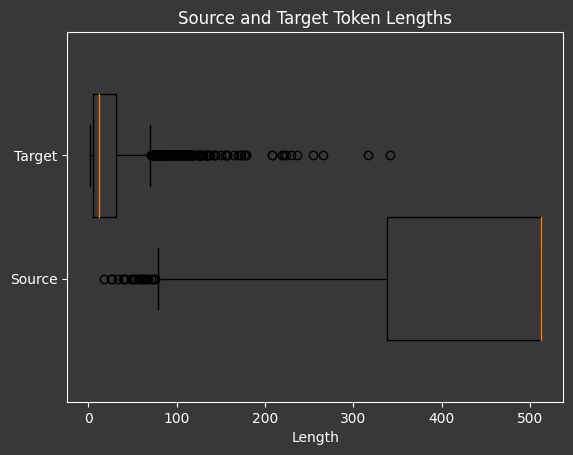

In [ ]:
concatenated_dataset = concatenate_datasets([dataset["train"], dataset["val"]])

# The maximum total input sequence length after tokenization.
tokenized_inputs = concatenated_dataset.map(lambda x: tokenizer(x["input"], truncation=True), batched=True, remove_columns=["input", "output"])
source_lengths = [len(x) for x in tokenized_inputs["input_ids"]]

# The maximum total sequence length for target text after tokenization.
tokenized_targets = concatenated_dataset.map(lambda x: tokenizer(x["output"], truncation=True), batched=True, remove_columns=["input", "output"])
target_lengths = [len(x) for x in tokenized_targets["input_ids"]]

# Create a figure and axis
fig, ax = plt.subplots()

# Create horizontal boxplots for both datasets
boxplot1 = ax.boxplot(source_lengths, vert=False, positions=[0.75], widths=0.5)
boxplot2 = ax.boxplot(target_lengths, vert=False, positions=[1.25], widths=0.5)

# Add labels and title
ax.set_yticklabels(["Source", "Target"])
ax.set_xlabel("Length")
ax.set_title("Source and Target Token Lengths")

# Show the plot
plt.show()

### Dataset: Tokenization

In [ ]:
def preprocess_function(sample):
    """
    Preprocesses input and output text data for a T5-style text generation model.

    Args:
        sample (dict): A dictionary containing input and output text data.
                       Expected keys: "input" for input text and "output" for output text.
        max_source_length (int): Maximum length of the input sequence after tokenization.
        max_target_length (int): Maximum length of the output sequence after tokenization.
        tokenizer: The tokenizer used for tokenization.

    Returns:
        dict: A dictionary containing processed model inputs and labels.
              The dictionary has keys: "input_ids" for input token IDs and "labels" for label token IDs.
    """

    # Tokenize inputs
    model_inputs = tokenizer(sample["input"], max_length=max_source_length, padding="max_length", truncation=True)

    # Tokenize targets with the `text_target` keyword argument
    labels = tokenizer(text_target=sample["output"], max_length=max_target_length, padding="max_length", truncation=True)

    # If we are padding here, replace all tokenizer.pad_token_id in the labels by -100 when we want to ignore
    # padding in the loss.
    labels["input_ids"] = [
        [(l if l != tokenizer.pad_token_id else -100) for l in label] for label in labels["input_ids"]
    ]

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [ ]:
# Define maximum token sequence lengths
max_source_length = 512
max_target_length = 128

# Tokenize the dataset
tokenized_dataset = dataset.map(preprocess_function, batched=True, remove_columns=["input", "output"])
keys = list(tokenized_dataset["train"].features)
print(f"Keys of tokenized dataset: {keys}")

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Keys of tokenized dataset: ['input_ids', 'attention_mask', 'labels']


In [ ]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 3000
    })
    val: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 200
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 800
    })
})

### Evaluation Metrics

In [ ]:
# Load BERTScore model
bert_scorer = bert_score.BERTScorer(lang="en", rescale_with_baseline=True)

def compute_metrics(eval_preds):
    """
    Compute evaluation metrics for a set of predicted sequences.

    Args:
        eval_preds (tuple): A tuple containing predicted token IDs and corresponding true token IDs.

    Returns:
        dict: A dictionary containing computed evaluation metrics.
              - 'bert_score_f1': BERTScore F1 score averaged across examples.
    """

    # Unpack predicted token IDs and true token IDs
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]

    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)

    # Convert token IDs back to text
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Compute BERTScore
    P, R, F1 = bert_scorer.score(decoded_preds, decoded_labels)

    # Return the mean score across all examples
    return {"BERT_F1_Score": F1.mean().item()}

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Data Collation

In [ ]:
# Ignore the pad token in the loss
label_pad_token_id = -100

# Load the base model
model = AutoModelForSeq2SeqLM.from_pretrained(base_model_name_hf)

# Data Collator
data_collator = DataCollatorForSeq2Seq(
    tokenizer,
    model=model,
    label_pad_token_id=label_pad_token_id,
    pad_to_multiple_of=8
)

### Fine-Tuning

In [ ]:
# Hugging Face repository id
output_dir = "flan_t5_finetuned"

# Define training args
training_args = Seq2SeqTrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    predict_with_generate=True,
    fp16=False,
    learning_rate=5e-5,
    num_train_epochs=5,
    logging_dir=f"{output_dir}/logs",
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True
)

# Create Trainer instance
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["val"],
    compute_metrics=compute_metrics,
)

In [ ]:
# Start the fine-tuning
trainer.train()

In [ ]:
# Push the fine-tuned model to HF
model.push_to_hub("flan-t5-base-clickbait-spoiling")
tokenizer.push_to_hub("flan-t5-base-clickbait-spoiling")

### Inference

In [ ]:
# load model and tokenizer from huggingface hub with pipeline
model = pipeline("text2text-generation", model="Mike-HF/flan-t5-base-clickbait-spoiling", device=0)

In [ ]:
# Suppress Hugging Face warnings
logging.getLogger("transformers").setLevel(logging.ERROR)

# Select a random test sample
x_test = dataset["test"][0:20]["input"]
y_true = dataset["test"][0:20]["output"]

# Generate the spoilers
y_pred = model(x_test, max_new_tokens=64)
y_pred = [y["generated_text"] for y in y_pred]

# Reset the logging level for "transformers" logger
logging.getLogger("transformers").setLevel(logging.WARNING)

In [ ]:
# Creating a DataFrame
data = {"Clickbait": x_test, "Prediction": y_pred, "Truth": y_true}
df = pd.DataFrame(data)

df

,Clickbait,Prediction,Truth
0,Title: Five Nights at Freddy’s Sequel Delayed ...,it’s too dark,some of the plot elements are so disturbing th...
1,Title: Why Arizona Sheriff Joe Arpaio’s fate c...,"""intentionally""","""intentionally"" - could transform a court case..."
2,Title: Here’s how much you should be tipping y...,20%,20%
3,"Title: Alan Rickman & Rupert Grint On 'CBGB,' ...",a yellow bin,Alan Rickman & Rupert Grint - CBGB
4,Title: Man swallowed a microSD card and you wo...,pooped it into a strainer,a man who swallowed a 64GB microSD card and th...
5,"Title: Sprite May Be The Best Hangover Cure, C...",Sprite,Sprite
6,Title: The Anytime Snack You Won't Feel Guilty...,Smoky Paprika-Baked Garbanzo Beans,Smoky Paprika-Baked Garbanzo Beans
7,Title: You Won’t Believe This Stunning ‘Harry ...,Professor McGonagall was originally hired by D...,McGonagall was appointed as Dumbledore’s assis...
8,Title: J.J. Abrams has an answer on if there w...,"""No, there’s not. All the scenes are actually ...",All the scenes are actually in the movie
9,Title: Kristin Cavallari Talks 'The Hills' Bei...,"""I had fake relationships, fake fights. I don'...","""I had fake relationships, fake fights. I don'..."
